# Question 3.6 (P113)

## Give a complete problem formulation for each of the following. Choose a formulation that is precise enough to be implemented.

### Using only four colors, you have to color a planar map in such a way that no two adjacent regions have the same color. 

# For example:
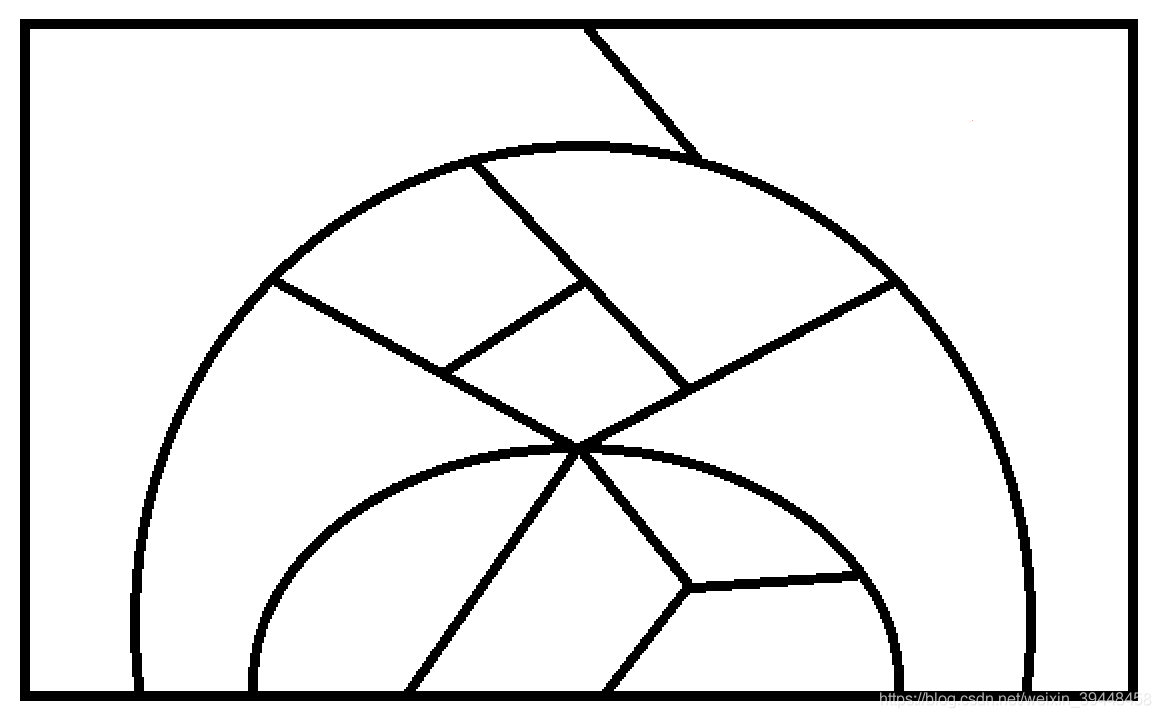

- First step: Divide the image into different regions and label them.

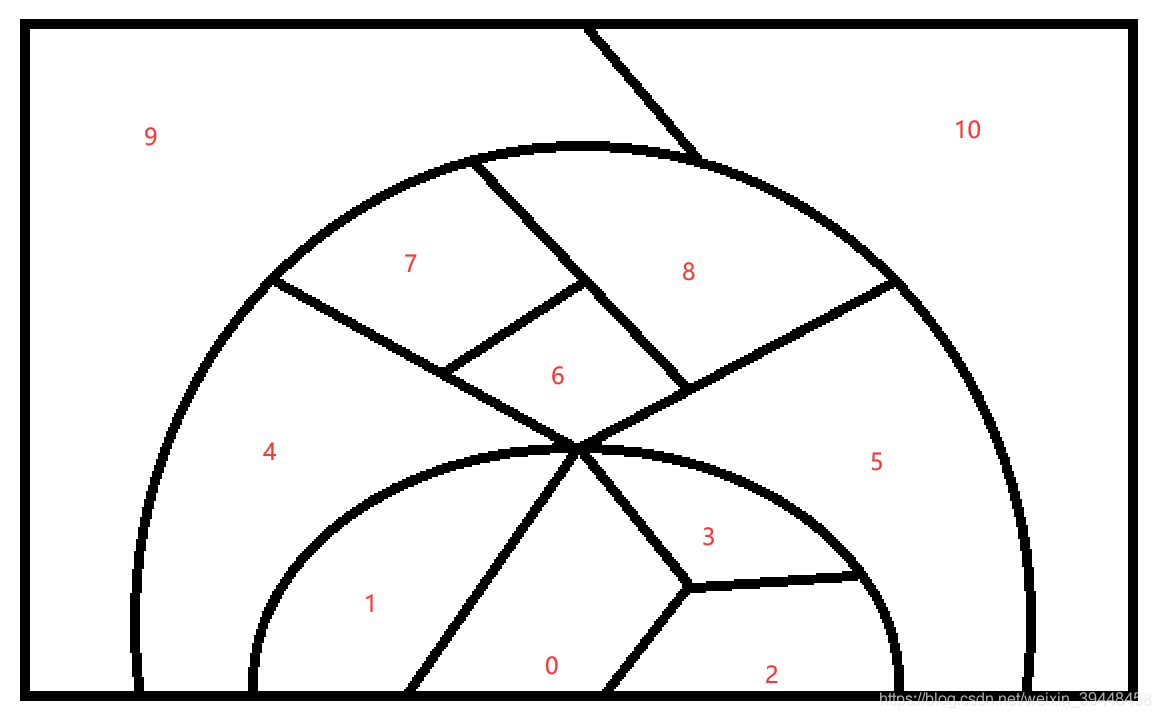

- Second step: Create the undirected graph, where all regions are mapped into the vertices of graph, if two regions are neighboring, then connect both in the graph.

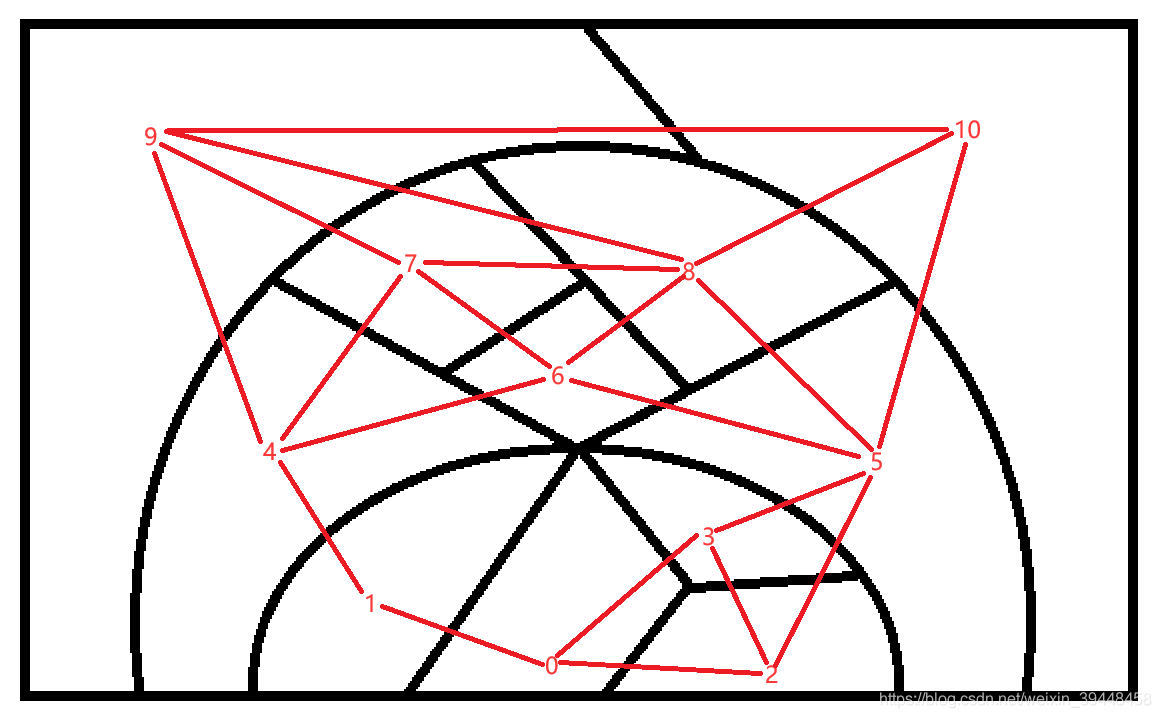

- Third step: Based on the undirected graph, create the adjacency matrx.

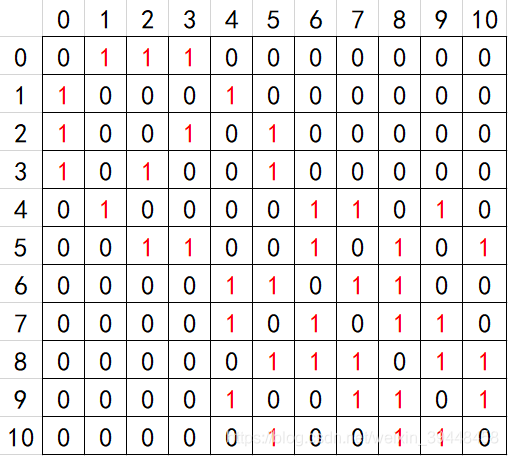

- Final step: Perform the search algorithm to find the solutions.

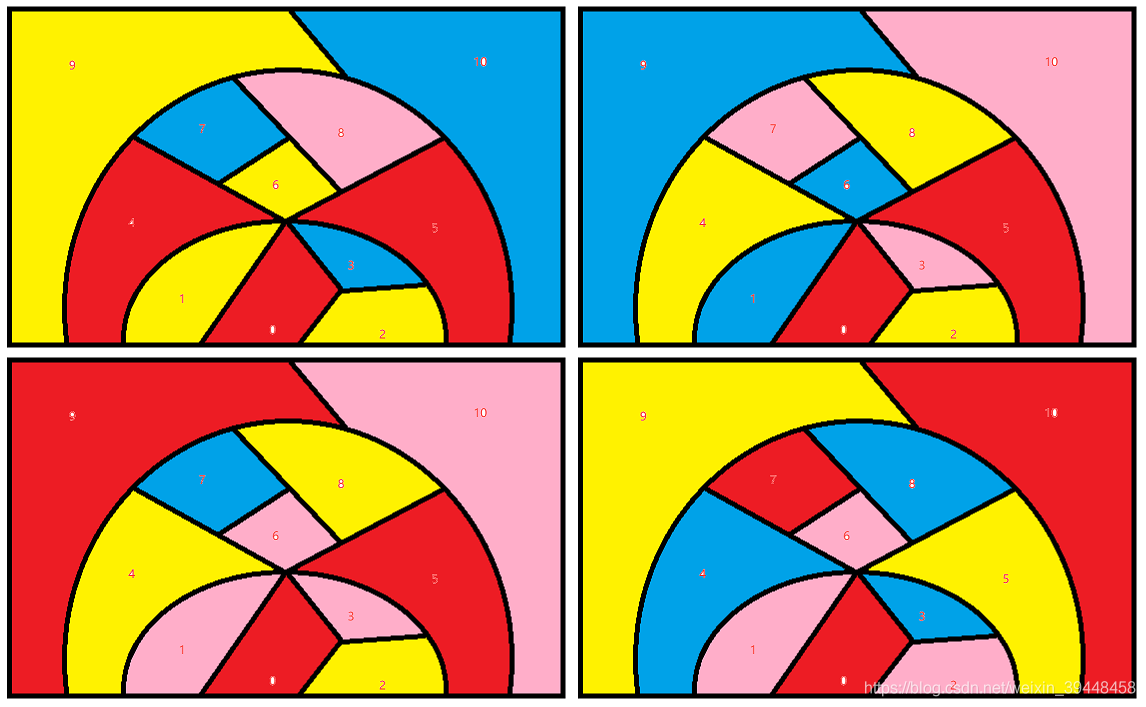

# Answers:
- Initial state: No regions colored. 
- Actions: Assign a color to an uncolored region. 
- Transition model: The previously uncolored region has the assigned color. 
- Goal test: All regions colored, and no two adjacent regions have the same color. 
- Cost function: Number of assignments. 

# Now let's implement the hands-on coding practices together! 

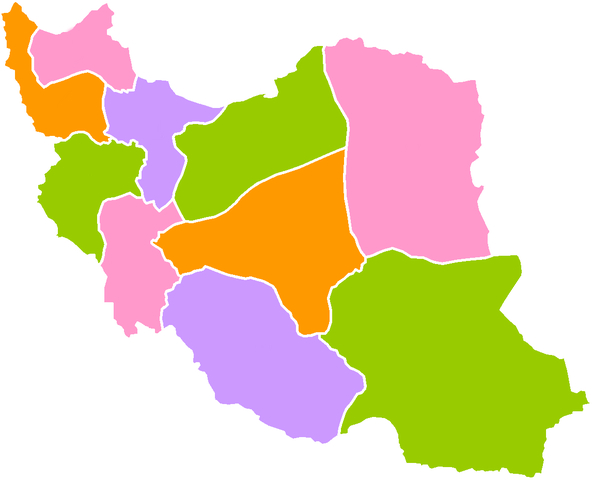

- Iran Atlas

# Required packages:
- cycler==0.10.0
- kiwisolver==1.1.0
- matplotlib==3.1.0
- numpy==1.16.4
- opencv-python==4.1.2.30
- pyparsing==2.4.0
- python-dateutil==2.8.0
- scipy==1.3.0
- six==1.12.0



In [1]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
from PIL import Image
import queue
import random
import psutil
import time
import datetime
try:
    MAP_IMAGE_PATH = "iran.jpg"
except IndexError:
    print("Error: please specify an image.")
    sys.exit()

Define a function to show image.

In [2]:
def show_image():
    img = Image.fromarray(image, 'RGB')
    img.show()

Specify the threshold to divide the image. Show the global variables.

In [3]:
count=0  ## recursive number
ESCAPE_KEY_CHARACTER = 27
NO_COLOR = -1
NOT_MARKED = -1
BACKGROUND_MARK = -2
SLEEP_TIME_IN_MILLISECONDS = 100
MINIMUM_BORDER_WIDTH_RATIO = 0.15
IMPORTANT_COLOR_HIGH_THRESHOLD = 256 - 35
IMPORTANT_COLOR_LOW_THRESHOLD = 35
MINIMUM_REGION_AREA_RATIO = 0.0005
MAXIMUM_NEIGHBOR_PIXEL_COLOR_DIFFERENCE = 50
INF = 10 ** 30
MAXIMUM_NUMBER_OF_REGIONS = 1000
COLORING_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]## define four colors
DX = [-1, +1, 0, 0] ##left, right, down, up
DY = [0, 0, -1, +1] ##left, right, down, up
SHARPEN_KERNEL = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
MAXIMUM_IMAGE_WIDTH = 1000
MAXIMUM_IMAGE_HEIGHT = 1000

Initialization.

In [4]:
image = cv2.imread(MAP_IMAGE_PATH, cv2.IMREAD_COLOR) ## input image
height = len(image)
width = len(image[0])
if width > MAXIMUM_IMAGE_WIDTH or height > MAXIMUM_IMAGE_HEIGHT:
    print("Error: please specify an image with smaller dimensions.")
    sys.exit()
total_area = width * height
mark = [[NOT_MARKED for i in range(width)] for j in range(height)] #mark matrix
nodes = [] ## node list
regions = [[] for i in range(MAXIMUM_NUMBER_OF_REGIONS)] # regions matrix
regions_border = [[] for i in range(MAXIMUM_NUMBER_OF_REGIONS)] # border matrix

Apply thresholds to discriminate regions from background.

In [5]:
def apply_threshold():
    for y in range(height):
        for x in range(width):
            b, g, r = image[y][x]
            r, g, b = int(r), int(g), int(b) # red, green, blue
            if r + g + b < IMPORTANT_COLOR_LOW_THRESHOLD * 3:
                image[y][x] = (255, 255, 255)
                mark[y][x] = BACKGROUND_MARK
            if r + g + b > IMPORTANT_COLOR_HIGH_THRESHOLD * 3:
                image[y][x] = (255, 255, 255)
                mark[y][x] = BACKGROUND_MARK
                

Remove noise from the image.

In [6]:
apply_threshold()
image = cv2.medianBlur(image, 3) #remove noise
apply_threshold()
image = cv2.filter2D(image, -1, SHARPEN_KERNEL) #remove noise
apply_threshold()

Define node structure.

In [7]:
class Node:
    def __init__(self, node_id, node_x, node_y):
        self.id = node_id
        self.x = node_x
        self.y = node_y
        self.adj = []
    def add_edge(self, node):
        self.adj.append(node.id)

Find the node in graph.

In [8]:
def is_inside(x, y):  ##judge the pixel inside the image
    if x < 0 or x >= width or y < 0 or y >= height:
        return False
    return True

def same_pixel_colors(x1, y1, x2, y2): #exist minor coloring differences
    if not is_inside(x1, y1) or not is_inside(x2, y2):
        return False
    b1, g1, r1 = image[y1][x1]
    b2, g2, r2 = image[y2][x2]
    r1, g1, b1 = int(r1), int(g1), int(b1)
    r2, g2, b2 = int(r2), int(g2), int(b2)
    diff = abs(r1 - r2) + abs(g1 - g2) + abs(b1 - b2)
    return diff <= 3 * MAXIMUM_NEIGHBOR_PIXEL_COLOR_DIFFERENCE

def is_on_border(x, y):
    if mark[y][x] == BACKGROUND_MARK: #background
        return False
    for k in range(4):
        x2 = x + DX[k]
        y2 = y + DY[k]
        if is_inside(x2, y2) and mark[y2][x2] == BACKGROUND_MARK: #start point is not background while neighbor point is background
            return True
    return False

def get_region_area(start_x, start_y, src_mark, dst_mark):
    if not is_inside(start_x, start_y) or mark[start_y][start_x] != src_mark: # if marked skip
        return 0
    color_area = 0
    queue = [(start_x, start_y)] #create a queue
    mark[start_y][start_x] = dst_mark # label the pixel
    while queue:
        x, y = queue.pop(0)
        mark[y][x] = dst_mark
        color_area += 1
        for k in range(4): #left, right, up, down
            x2 = x + DX[k]
            y2 = y + DY[k]
            if is_inside(x2, y2) and mark[y2][x2] == src_mark and same_pixel_colors(x, y, x2, y2):
                mark[y2][x2] = dst_mark
                queue.append((x2, y2))
    return color_area

def get_all_regions_pixels():
    for y in range(height):
        for x in range(width):
            region_mark = mark[y][x]  #group pixels into each region
            regions[region_mark].append((x, y))
            if is_on_border(x, y): # if on border, add to the region border matrix
                regions_border[region_mark].append((x, y))

def find_graph_nodes():
    for y in range(height):
        for x in range(width):
            if mark[y][x] == NOT_MARKED:
                color_area = get_region_area(x, y, NOT_MARKED, len(nodes))
                if color_area > MINIMUM_REGION_AREA_RATIO * total_area: #region needs to be larger than the minimum area
                    nodes.append(Node(len(nodes), x, y))
                else:
                    get_region_area(x, y, len(nodes), NOT_MARKED) #otherwise mark as background
    get_all_regions_pixels()
    
find_graph_nodes()

Next we need to append edges to the graph.

In [9]:
def are_adjacent(node1:Node, node2:Node):
    start_x, start_y = node1.x, node1.y #node 1 start point
    end_x, end_y = node2.x, node2.y #node 2 start point
    min_distance_sqr = INF
    for u in regions_border[mark[start_y][start_x]]: #find the nearest points between two regions
        for v in regions_border[mark[end_y][end_x]]:
            tmp_distance_sqr = (u[0] - v[0]) **2 + (u[1] - v[1]) **2
            if tmp_distance_sqr < min_distance_sqr:
                min_distance_sqr = tmp_distance_sqr
                start_x, start_y = u[0], u[1] #reset
                end_x, end_y = v[0], v[1]
    dx, dy = end_x - start_x, end_y - start_y
    if abs(dx) + abs(dy) <= 1: #adjacent
        return True
    dx, dy = float(dx), float(dy)
    border_width_threshold = MINIMUM_BORDER_WIDTH_RATIO * (width * width + height * height)
    if min_distance_sqr >= border_width_threshold: #global judge
        return False
    total_steps = int(2 * ((width **2 + height **2) ** 0.5))
    for i in range(total_steps): #local search
        x = int(start_x + i * dx / total_steps + 0.5)
        y = int(start_y + i * dy / total_steps + 0.5)
        if mark[y][x] >= 0 and (x != start_x or y != start_y) and (x != end_x or y != end_y):
            return False
    return True

def add_graph_edges():
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            if j > i and are_adjacent(nodes[i], nodes[j]): #judge whether node i and node j are neighboring
                nodes[i].add_edge(nodes[j])
                nodes[j].add_edge(nodes[i])

add_graph_edges()

Whiten the background.

In [10]:
def whiten_background():
    for y in range(height):
        for x in range(width):
            if mark[y][x] == NOT_MARKED or mark[y][x] == BACKGROUND_MARK:
                image[y][x] = (255, 255, 255)
whiten_background()

Preprocessing is finished.

Let's review pseudo code of General Tree Search, prior to the implementation of search algorithms.

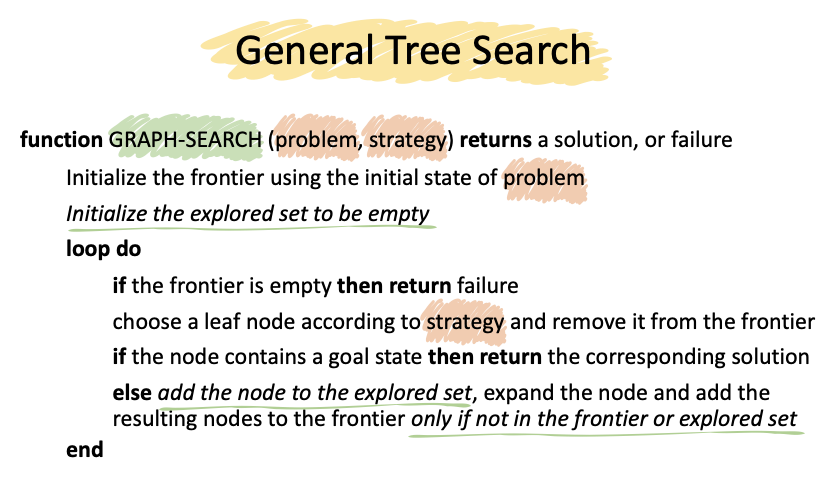

Now we need to confirm the goal state:

1) No two adjacent regions have the same color;

2) All regions are colored.

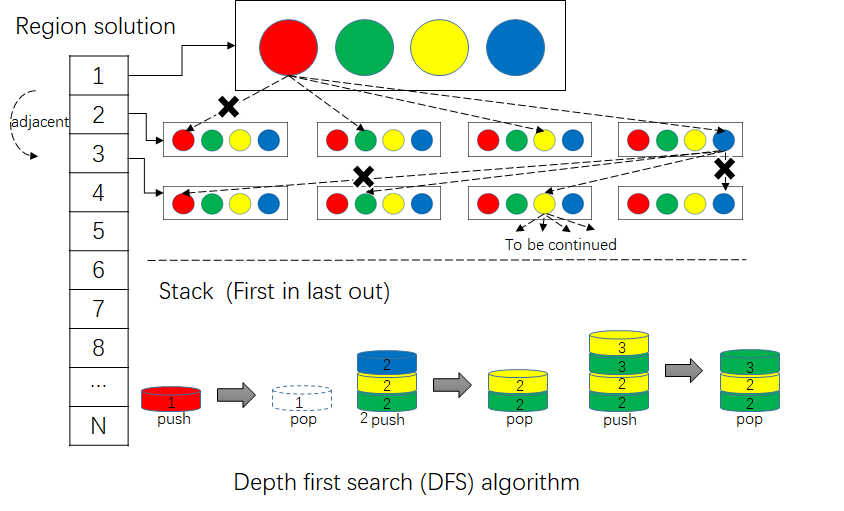

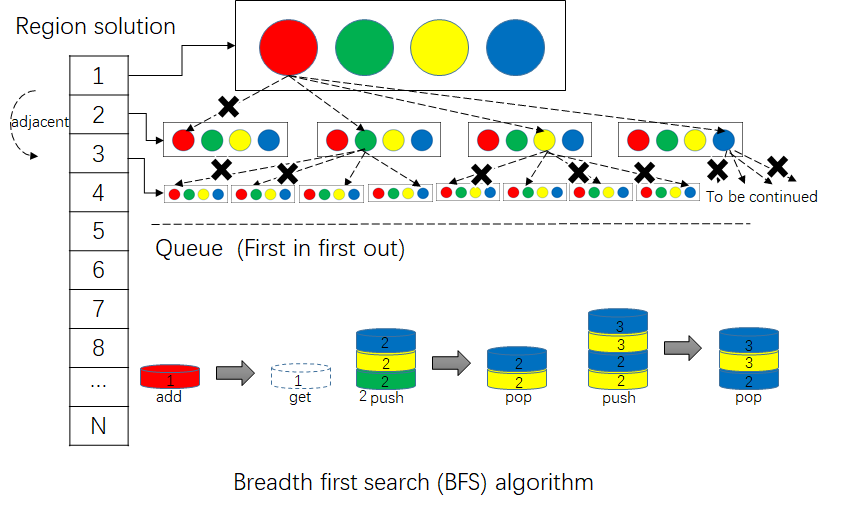

Define the tree node

In [11]:
class tNode(object): #tree node
    def __init__(self, id):
        self.id = id
        self.path = [NO_COLOR for i in range(len(nodes))] #initialize the path (solution)

Define a founction to check next state

In [12]:
def check(id, path): 
    for i in range(id):# id: depth-1
        for u in nodes[i].adj:
            if path[u] == path[i]:
                return False
    return True

Define a function to change region's color for a target region

In [13]:
def change_region_color(node:Node, pixel_color): # coloring all pixel in the same region
    region_idx = mark[node.y][node.x]
    for i in range(len(regions[region_idx])):
        x = regions[region_idx][i][0]
        y = regions[region_idx][i][1]
        image[y][x] = pixel_color

Define the DFS function using a stack.

In [14]:
def DFS(color): # color for the first region
    ##DFS
    starttime = datetime.datetime.now()
    
    Start = tNode(0)
    Start.path[0] = color
    frontier = [] #stack
    frontier.append(Start)#push start node
    visited = set() # initialize the expplored set
    visited.add(0)
    scanned_regions  = 1
    
    while True:
        if len(frontier) == 0: #empty
            print("Failure.")
            return False
        cur = frontier.pop()
        for i in range(len(COLORING_COLORS)):
            temp_path = cur.path[:]
            temp_path[cur.id+1] = i
            if check(cur.id+2, temp_path): #if true, generate the node
                ##visulization for each step
#                 for j in range(len(nodes)):
#                     change_region_color(nodes[j], COLORING_COLORS[temp_path[j]])
#                 cv2.imshow('Colorized Map', image)
#                 key = cv2.waitKey(SLEEP_TIME_IN_MILLISECONDS)
#                 if key == ESCAPE_KEY_CHARACTER:
#                     cv2.destroyAllWindows()         
#                     exit()
                visited.add(cur.id + 1)  #mark region id
                if scanned_regions == len(visited) -1:
                    scanned_regions += 1
                    endtime = datetime.datetime.now()
                    duringtime = endtime-starttime
                    print("Scanning "+str(scanned_regions)+" regions using "+str(duringtime.seconds)+" seconds.")
                node = tNode(cur.id + 1)
                node.path = temp_path[:]
                frontier.append(node)
                if len(visited) == len(nodes): #goal test
                    return node.path

Define the BFS function using a queue.

In [15]:
def BFS(color): # color for the first region
    ##BFS
    starttime = datetime.datetime.now()
    
    Start = tNode(0)
    Start.path[0] = color
    frontier = queue.Queue()
    frontier.put(Start) #push start node
    visited = set() # initialize the expplored set
    visited.add(0)
    scanned_regions = 1
    while True:
        if frontier.empty():
            print("Failure.")
            return False
        cur = frontier.get()
        for i in range(len(COLORING_COLORS)):
            temp_path = cur.path[:]
            temp_path[cur.id + 1] = i
            if check(cur.id + 2, temp_path): #if true, generate the node
                ##visulization for each step
                for j in range(len(nodes)):
                    change_region_color(nodes[j], COLORING_COLORS[temp_path[j]])
                cv2.imshow('Colorized Map', image)
                key = cv2.waitKey(SLEEP_TIME_IN_MILLISECONDS)
                if key == ESCAPE_KEY_CHARACTER:
                    cv2.destroyAllWindows()         
                    exit()
                visited.add(cur.id + 1) #mark region id
                if scanned_regions == len(visited) - 1:
                    scanned_regions += 1
                    endtime = datetime.datetime.now()
                    duringtime = endtime-starttime
                    print("Scanning "+str(scanned_regions)+" regions using "+str(duringtime.seconds)+" seconds.")
                node = tNode(cur.id+1)
                node.path = temp_path[:]
                frontier.put(node)
                if len(visited) == len(nodes): #goal test
                    return node.path

As shown in the codes, DFS and BFS are very similar to each other.

However, we can find an significant difference between both in terms of efficiency.

Now we perform the DFS algorithm first.

In [16]:
solution = list(DFS(0))
for i in range(len(solution)):
    change_region_color(nodes[i], COLORING_COLORS[solution[i]])
show_image()

Scanning 2 regions using 0 seconds.
Scanning 3 regions using 1 seconds.
Scanning 4 regions using 2 seconds.
Scanning 5 regions using 3 seconds.
Scanning 6 regions using 3 seconds.
Scanning 7 regions using 3 seconds.
Scanning 8 regions using 4 seconds.
Scanning 9 regions using 4 seconds.
Scanning 10 regions using 5 seconds.


Next we perform the BFS algorithm.

In [17]:
solution = list(BFS(0))
for i in range(len(solution)):
    change_region_color(nodes[i], COLORING_COLORS[solution[i]])
show_image()

Scanning 2 regions using 0 seconds.
Scanning 3 regions using 1 seconds.
Scanning 4 regions using 4 seconds.
Scanning 5 regions using 14 seconds.
Scanning 6 regions using 29 seconds.
Scanning 7 regions using 59 seconds.
Scanning 8 regions using 118 seconds.
Scanning 9 regions using 170 seconds.
Scanning 10 regions using 275 seconds.



# Acknowledge: 
This tutorial is partially based on the github repository https://github.com/Erfaniaa/map-coloring.